In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath('..'))

from log_processing import process_log

In [54]:
log_file = "../../backtests/test.log"
trader_data, products_data, activities, trades = process_log(log_file)

In [55]:
PRODUCT = "SQUID_INK"
product_data = products_data[PRODUCT]
activities = activities[activities["product"] == PRODUCT].reset_index()

In [56]:
price = product_data["current_price"]
percentage_diff = product_data["percentage_diff"]

timestamps = activities["timestamp"]

bp1 = activities["bid_price_1"]
bv1 = activities["bid_volume_1"]
bp2 = activities["bid_price_2"]
bv2 = activities["bid_volume_2"]
bp3 = activities["bid_price_3"]
bv3 = activities["bid_volume_3"]

ap1 = activities["ask_price_1"]
av1 = activities["ask_volume_1"]
ap2 = activities["ask_price_2"]
av2 = activities["ask_volume_2"]
ap3 = activities["ask_price_3"]
av3 = activities["ask_volume_3"]

sm = product_data["short_mean"]
lm = product_data["long_mean"]

trades = trades[trades["symbol"] == PRODUCT].reset_index()
own_trades = trades[(trades["buyer"] == "SUBMISSION") | (trades["seller"] == "SUBMISSION")]

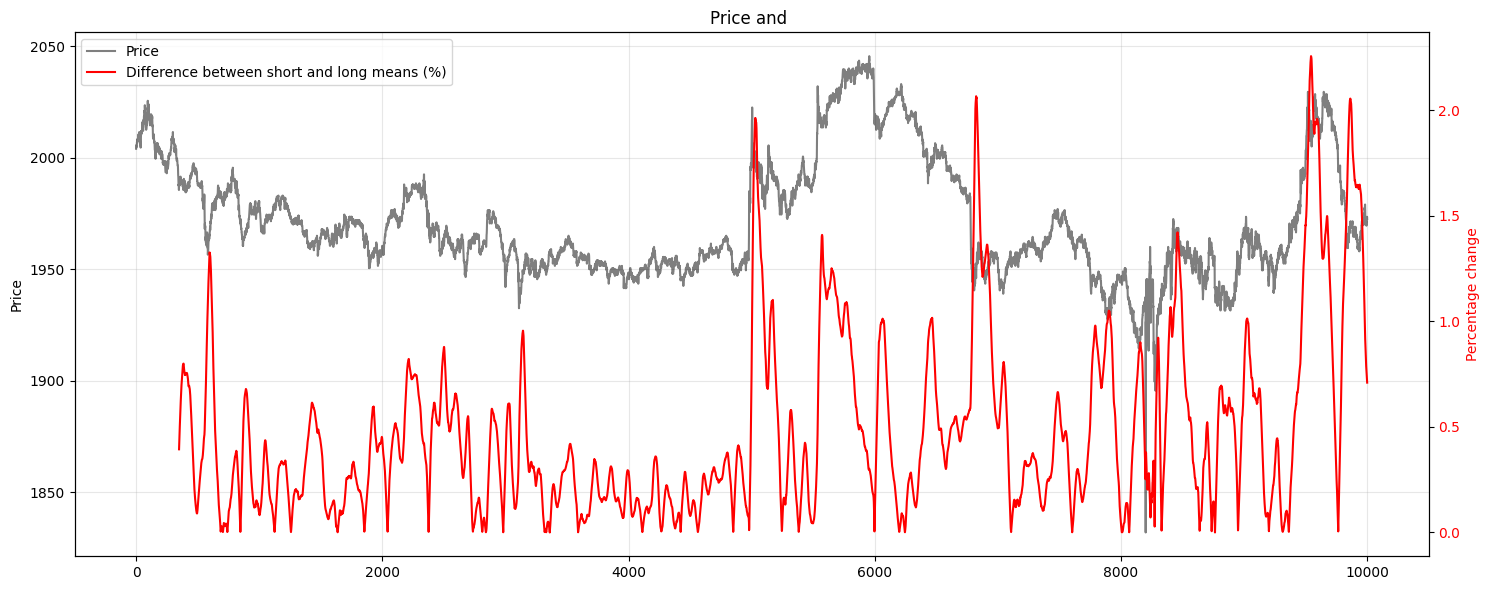

In [57]:
fig, ax1 = plt.subplots(figsize=(15, 6))

# Plot price on primary axis
ax1.plot(price, label="Price", color="black", alpha=0.5)
ax1.set_ylabel('Price', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, alpha=0.3)

# Create secondary y-axis for volatility
ax2 = ax1.twinx()
ax2.plot(percentage_diff * 100, label="Difference between short and long means (%)", color="red", linewidth=1.5)
ax2.set_ylabel('Percentage change', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add legends with multiple axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title('Price and ')
plt.tight_layout()
plt.show()

/var/folders/4_/nj45w49n4nq1x2nm00vm98dw0000gn/T/ipykernel_68257/159843961.py:191: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  signals['cumulative_pl'] = signals['cumulative_pl'].replace(0, np.nan).fillna(method='ffill').fillna(0)


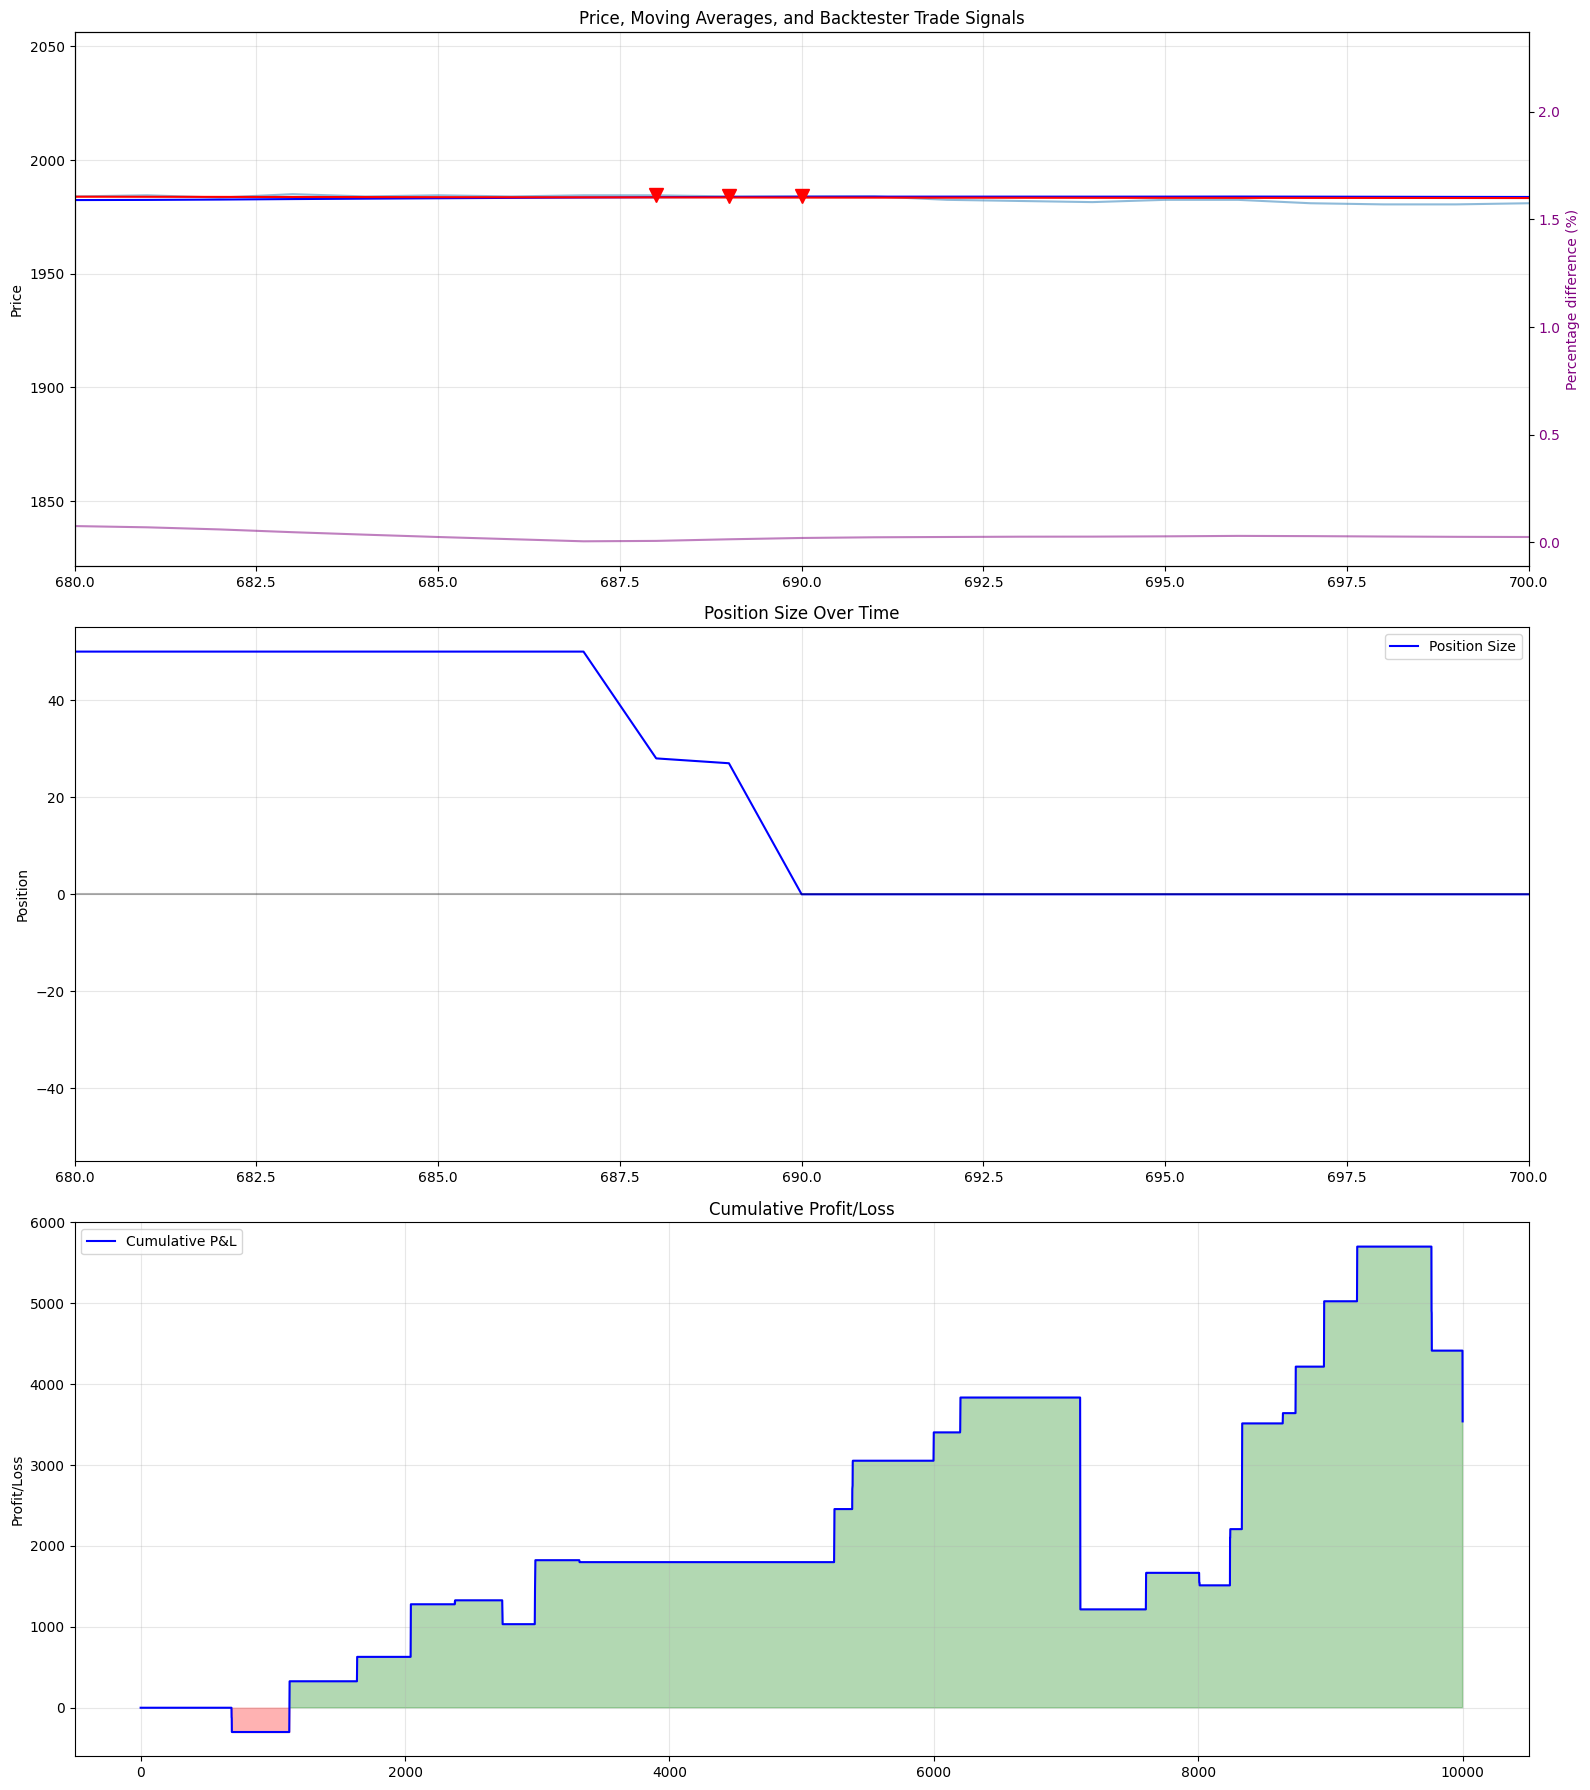

In [ ]:
# Use the price series from your data
price_series = pd.Series(price)


# Create signals dataframe
signals = pd.DataFrame(index=price_series.index)

signals['price'] = price_series
signals['timestamp'] = timestamps
signals['short_ma'] = sm
signals['long_ma'] = lm
signals['bid_price_1'] = bp1
signals['bid_volume_1'] = bv1
signals['ask_price_1'] = ap1
signals['ask_volume_1'] = av1
signals['signal'] = 0.0  # Initialize all signals to 0
signals['quantity'] = 0.0  # Initialize quantity to 0

# Calculate percentage difference between moving averages (for visualization purposes)
signals['percentage_diff'] = abs(signals['long_ma'] - signals['short_ma']) / signals['price']

# Get the sell and buy signals from your backtest logs
sell_signals = own_trades[own_trades["seller"] == "SUBMISSION"]
buy_signals = own_trades[own_trades["buyer"] == "SUBMISSION"]

# Set signals based on timestamp matching
for idx, trade in sell_signals.iterrows():
    matching_indices = signals[signals['timestamp'] == trade['timestamp']].index
    if not matching_indices.empty:
        signals.loc[matching_indices, 'signal'] = -1.0  # Mark sell signals
        signals.loc[matching_indices, 'quantity'] = trade['quantity']  # Set quantity for sell signals

for idx, trade in buy_signals.iterrows():
    matching_indices = signals[signals['timestamp'] == trade['timestamp']].index
    if not matching_indices.empty:
        signals.loc[matching_indices, 'signal'] = 1.0  # Mark buy signals
        signals.loc[matching_indices, 'quantity'] = trade['quantity']

# Create positions column to identify entry/exit points
signals['positions'] = signals['signal'].diff()

# Initialize columns to track trades and performance
signals['trade_price'] = np.nan
signals['trade_type'] = ''
signals['profit_loss'] = np.nan
signals['cumulative_pl'] = 0.0

# Track whether we're in a position and the entry price
position = 0
entry_price = 0
entry_idx = None
total_profit_loss = 0

# Track entry and exit pairs
entries = []
exits = []
entry_types = []  # To track if entry was a long or short position
entry_quantities = []  # Add this to track quantities
profits = []
positions = []

# Loop through the signals to identify complete trades
for i in range(len(signals)):
    current_idx = signals.index[i]
    
    # Buy signal (position increased)
    if signals.loc[current_idx, 'signal'] == 1.0:
        signals.loc[current_idx, 'trade_price'] = signals.loc[current_idx, 'ask_price_1']
        signals.loc[current_idx, 'trade_type'] = 'BUY'
        order_vol = signals.loc[current_idx, 'quantity']

        # If we're already short, this is a position exit
        if position < 0:
            
            exit_price = signals.loc[current_idx, 'ask_price_1']
            profit_loss = (entry_price - exit_price) * order_vol # For short positions, profit when exit < entry
            signals.loc[current_idx, 'profit_loss'] = profit_loss 
            total_profit_loss += profit_loss
            
            exits.append(current_idx)
            profits.append(profit_loss)
            
            position += order_vol
        else:
            # New long position
            position += order_vol
            entry_price = signals.loc[current_idx, 'price']
            entry_idx = current_idx
            entries.append(entry_idx)
            entry_types.append('LONG')
            entry_quantities.append(order_vol)  # Add this line
    
    # Sell signal (position decreased)
    elif signals.loc[current_idx, 'signal'] == -1.0:
        signals.loc[current_idx, 'trade_price'] = signals.loc[current_idx, 'bid_price_1']
        signals.loc[current_idx, 'trade_type'] = 'SELL'
        order_vol = signals.loc[current_idx, 'quantity']
        # If we're already long, this is a position exit
        if position > 0:
            exit_price = signals.loc[current_idx, 'bid_price_1']
            profit_loss = (exit_price - entry_price) * order_vol  # For long positions, profit when exit > entry
            signals.loc[current_idx, 'profit_loss'] = profit_loss 
            total_profit_loss += profit_loss
            
            exits.append(current_idx)
            profits.append(profit_loss)
            
            position -= order_vol
        else:
            # New short position
            position -= order_vol
            entry_price = signals.loc[current_idx, 'price']
            entry_idx = current_idx
            entries.append(entry_idx)
            entry_types.append('SHORT')
            entry_quantities.append(order_vol)  # Add this line
    
    signals.loc[current_idx, 'cumulative_pl'] = total_profit_loss
    positions.append(position)

if position != 0:
    last_idx = signals.index[-1]
    
    if position > 0:  # Long position
        # Sell at the last bid price
        exit_price = signals.loc[last_idx, 'bid_price_1']
        profit_loss = (exit_price - entry_price) * position
        
        signals.loc[last_idx, 'trade_type'] = 'SELL'
        signals.loc[last_idx, 'trade_price'] = exit_price
        signals.loc[last_idx, 'profit_loss'] = profit_loss
        
        # Update cumulative P&L
        total_profit_loss += profit_loss
        signals.loc[last_idx, 'cumulative_pl'] = total_profit_loss
        
        # Record the exit
        exits.append(last_idx)
        profits.append(profit_loss)
        
    elif position < 0:  # Short position
        # Buy at the last ask price
        exit_price = signals.loc[last_idx, 'ask_price_1']
        profit_loss = (entry_price - exit_price) * abs(position)
        
        signals.loc[last_idx, 'trade_type'] = 'BUY'
        signals.loc[last_idx, 'trade_price'] = exit_price
        signals.loc[last_idx, 'profit_loss'] = profit_loss
        
        # Update cumulative P&L
        total_profit_loss += profit_loss
        signals.loc[last_idx, 'cumulative_pl'] = total_profit_loss
        
        # Record the exit
        exits.append(last_idx)
        profits.append(profit_loss)
    

# Create a summary of completed trades
if len(entries) > len(exits):
    # Remove last entry if it has no matching exit
    entries.pop()
    entry_types.pop()

# # Create trade summary for completed trades only
# trade_summary = []
# for i in range(len(exits)):
#     entry_idx = entries[i]
#     exit_idx = exits[i]
#     entry_type = entry_types[i]
    
#     entry_price = signals.loc[entry_idx, 'price']
#     exit_price = signals.loc[exit_idx, 'price']
#     quantity = entry_quantities[i]  # Get the stored quantity
    
#     if entry_type == 'LONG':
#         profit = (exit_price - entry_price) * quantity
#     else:  # SHORT
#         profit = (entry_price - exit_price) * quantity
    
#     trade_summary.append({
#         'Entry Time': entry_idx,
#         'Exit Time': exit_idx,
#         'Type': entry_type,
#         'Entry Price': entry_price,
#         'Exit Price': exit_price,
#         'Profit/Loss': profit
#     })

# After all trades are processed, perform a forward fill to ensure continuous plot
signals['cumulative_pl'] = signals['cumulative_pl'].replace(0, np.nan).fillna(method='ffill').fillna(0)

# For any remaining NaN values at the beginning (if any)
signals['cumulative_pl'] = signals['cumulative_pl'].fillna(0)

# trade_df = pd.DataFrame(trade_summary)

# # Print performance metrics
# num_trades = len(trade_df)
# win_trades = sum(1 for p in trade_df['Profit/Loss'] if p > 0)
# lose_trades = sum(1 for p in trade_df['Profit/Loss'] if p < 0)
# win_rate = (win_trades / num_trades * 100) if num_trades > 0 else 0
# avg_profit = trade_df['Profit/Loss'].mean() if num_trades > 0 else 0
# max_profit = trade_df['Profit/Loss'].max() if num_trades > 0 else 0
# max_loss = trade_df['Profit/Loss'].min() if num_trades > 0 else 0

# print(f"Total Trades: {num_trades}")
# print(f"Winning Trades: {win_trades} ({win_rate:.2f}%)")
# print(f"Losing Trades: {lose_trades}")
# print(f"Total P&L: {total_profit_loss:.2f}")
# print(f"Average P&L per Trade: {avg_profit:.2f}")
# print(f"Maximum Profit: {max_profit:.2f}")
# print(f"Maximum Loss: {max_loss:.2f}")

plt.figure(figsize=(16, 18))  # Make figure taller to accommodate 3 subplots

# Plot 1: Price and MAs with buy/sell signals
plt.subplot(3, 1, 1)  # 3 rows, 1 column, first subplot
ax1 = plt.gca()
ax1.plot(signals['price'], label='Price', alpha=0.5)
ax1.plot(signals['short_ma'], label='Short MA', color='blue')
ax1.plot(signals['long_ma'], label='Long MA', color='red')

# Plot buy signals from backtester logs
buy_points = signals[signals['signal'] == 1.0]
ax1.plot(buy_points.index, buy_points['price'],
         '^', markersize=10, color='g', label='Buy Signal (Backtester)')

# Plot sell signals from backtester logs
sell_points = signals[signals['signal'] == -1.0]
ax1.plot(sell_points.index, sell_points['price'],
         'v', markersize=10, color='r', label='Sell Signal (Backtester)')

# Create secondary y-axis for percentage difference between MAs
ax2 = ax1.twinx()
ax2.plot(signals['percentage_diff'] * 100, label="Difference between short and long MAs (%)", 
         color="purple", linewidth=1.5, alpha=0.5)
ax2.set_ylabel('Percentage difference (%)', color='purple')
ax2.tick_params(axis='y', labelcolor='purple')

# Set up legend and title
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
# ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper left')
ax1.set_title('Price, Moving Averages, and Backtester Trade Signals')
ax1.grid(True, alpha=0.3)
ax1.set_ylabel('Price')

# plt.xlim([680, 700])

# Plot 2: Positions plot
plt.subplot(3, 1, 2)  # 3 rows, 1 column, second subplot
plt.plot(signals.index, positions, color='blue', label='Position Size')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.legend()
plt.title('Position Size Over Time')
plt.grid(True, alpha=0.3)
plt.ylabel('Position')

# plt.xlim([680, 700])

# Plot 3: Cumulative P&L
plt.subplot(3, 1, 3)  # 3 rows, 1 column, third subplot
plt.plot(signals.index, signals['cumulative_pl'], color='blue', label='Cumulative P&L')
plt.fill_between(signals.index, signals['cumulative_pl'], 0, 
                 where=(signals['cumulative_pl'] >= 0), color='green', alpha=0.3)
plt.fill_between(signals.index, signals['cumulative_pl'], 0, 
                 where=(signals['cumulative_pl'] < 0), color='red', alpha=0.3)
plt.legend()
plt.title('Cumulative Profit/Loss')
plt.grid(True, alpha=0.3)
plt.ylabel('Profit/Loss')



plt.tight_layout()
plt.show()

# # Display trade summary
# if len(trade_df) > 0:
#     display(trade_df)